In [44]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
np.random.seed(0)


In [45]:
r_shade_roi = np.linspace(0.01, 4, 100)
eta_shade_roi = np.linspace(-0.1, 0.1, 100)
beta_shade_roi = (eta_shade_roi + 1.5)/r_shade_roi
r_roi_mesh, eta_roi_mesh = np.meshgrid(r_shade_roi, eta_shade_roi)
beta_roi_mesh = (eta_roi_mesh + 1.5) / r_roi_mesh
roi_points = np.column_stack([r_roi_mesh.ravel(), (1 / beta_roi_mesh).ravel()])
roi_hull = ConvexHull(roi_points)

# Coco

## Indoor

In [46]:
DATA_SET = "coco"
TYPE = "indoor"

In [47]:
kind = "layer"
all_hulls_df = pd.DataFrame(columns=["BAND", "hull", "CHANNEL", "DIRECTION"])
for DIRECTION in ["horizontal", "diagonal", "vertical"]:
    for CHANNEL in ["gray", "blue", "green", "red"]:
        DATA_NAME = f'{DATA_SET}-{TYPE}' 
        TRANSFORM = f'wavelet-{DIRECTION}'
        CHANNEL = CHANNEL

        path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
        
        if CHANNEL:
            path_list.append(CHANNEL)
        print(path_list)
        ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
        CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)


        DICT_PATH = os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle")
        MASTERDF_DIR = os.path.join(CWD, "CSVs", "master_df.csv")
        rEtaKsstats_dict = pd.read_pickle(DICT_PATH)
        master_df = pd.read_csv(MASTERDF_DIR)
        master_df = master_df.set_index("layer")
        master_df
        hulls_df = region_reporting(rEtaKsstats_dict, master_df, layer = "all", MULT =1.2, kind = kind, plots=False, plot_name = "-".join(path_list))
        hulls_df["CHANNEL"] = CHANNEL
        hulls_df["DIRECTION"] = DIRECTION
        all_hulls_df = pd.concat([all_hulls_df, hulls_df], ignore_index=True)
all_hulls_df = all_hulls_df.reset_index(drop=True)
all_hulls_df

['coco', 'indoor', 'wavelet', 'horizontal', 'gray']
['r_optimize', 'eta_optimize', 'ksstat_exclude_plus0']
0.10833492941054608 0.0338043827653032
Layer 2: None Passed
Rational Function Parameters: a=0.04598563045415291, b=1.957953240811924, c=1.5069295273684822, d=-0.22716443728457392, e=11.697738663547652
Quadratic Function Parameters: a=0.013080609533038468, b=0.12725472613280808, c=0.1901057403866181
Linear Function Parameters: m=0.29873729009049543, c=-0.21461657001386314
['r_optimize', 'eta_optimize', 'ksstat_exclude_plus0']
0.07388205964693713 0.0169288482553685
Layer 3: None Passed
Rational Function Parameters: a=1.2118720404154975, b=1.4040310072677236, c=-0.552859525450484, d=0.6476905204310773, e=0.5929065963245507
Quadratic Function Parameters: a=-0.002815009292306782, b=1.9526874596346322, c=-0.15153547255686348
Linear Function Parameters: m=1.904626841949856, c=-0.006756758970139165
['r_optimize', 'eta_optimize', 'ksstat_exclude_plus0']
0.06982057662804841 0.00847100356038

BAND                                               hull CHANNEL   DIRECTION
0     2  [[3.000705770778379, 4.477828817434899], [0.09...    gray  horizontal
1     3  [[20.00151042630192, 40.000517790828056], [19....    gray  horizontal
2     4  [[19.998664655022413, 49.99858713577317], [20....    gray  horizontal
3     5  [[19.99873575152103, 66.66589923401511], [20.0...    gray  horizontal
4     6  [[20.00127810535815, 66.66773757169511], [19.9...    gray  horizontal
..  ...                                                ...     ...         ...
91    5  [[20.00076353845465, 99.99993408202599], [20.0...     red    vertical
92    6  [[20.00135783832815, 200.000698010909], [0.700...     red    vertical
93    7  [[20.002098833787976, 22.22154124090718], [19....     red    vertical
94    8  [[20.002212798001928, 1.3775257826399612], [19...     red    vertical
95    9  [[20.00237719664262, 15.385733587398184], [19....     red    vertical

[96 rows x 4 columns]

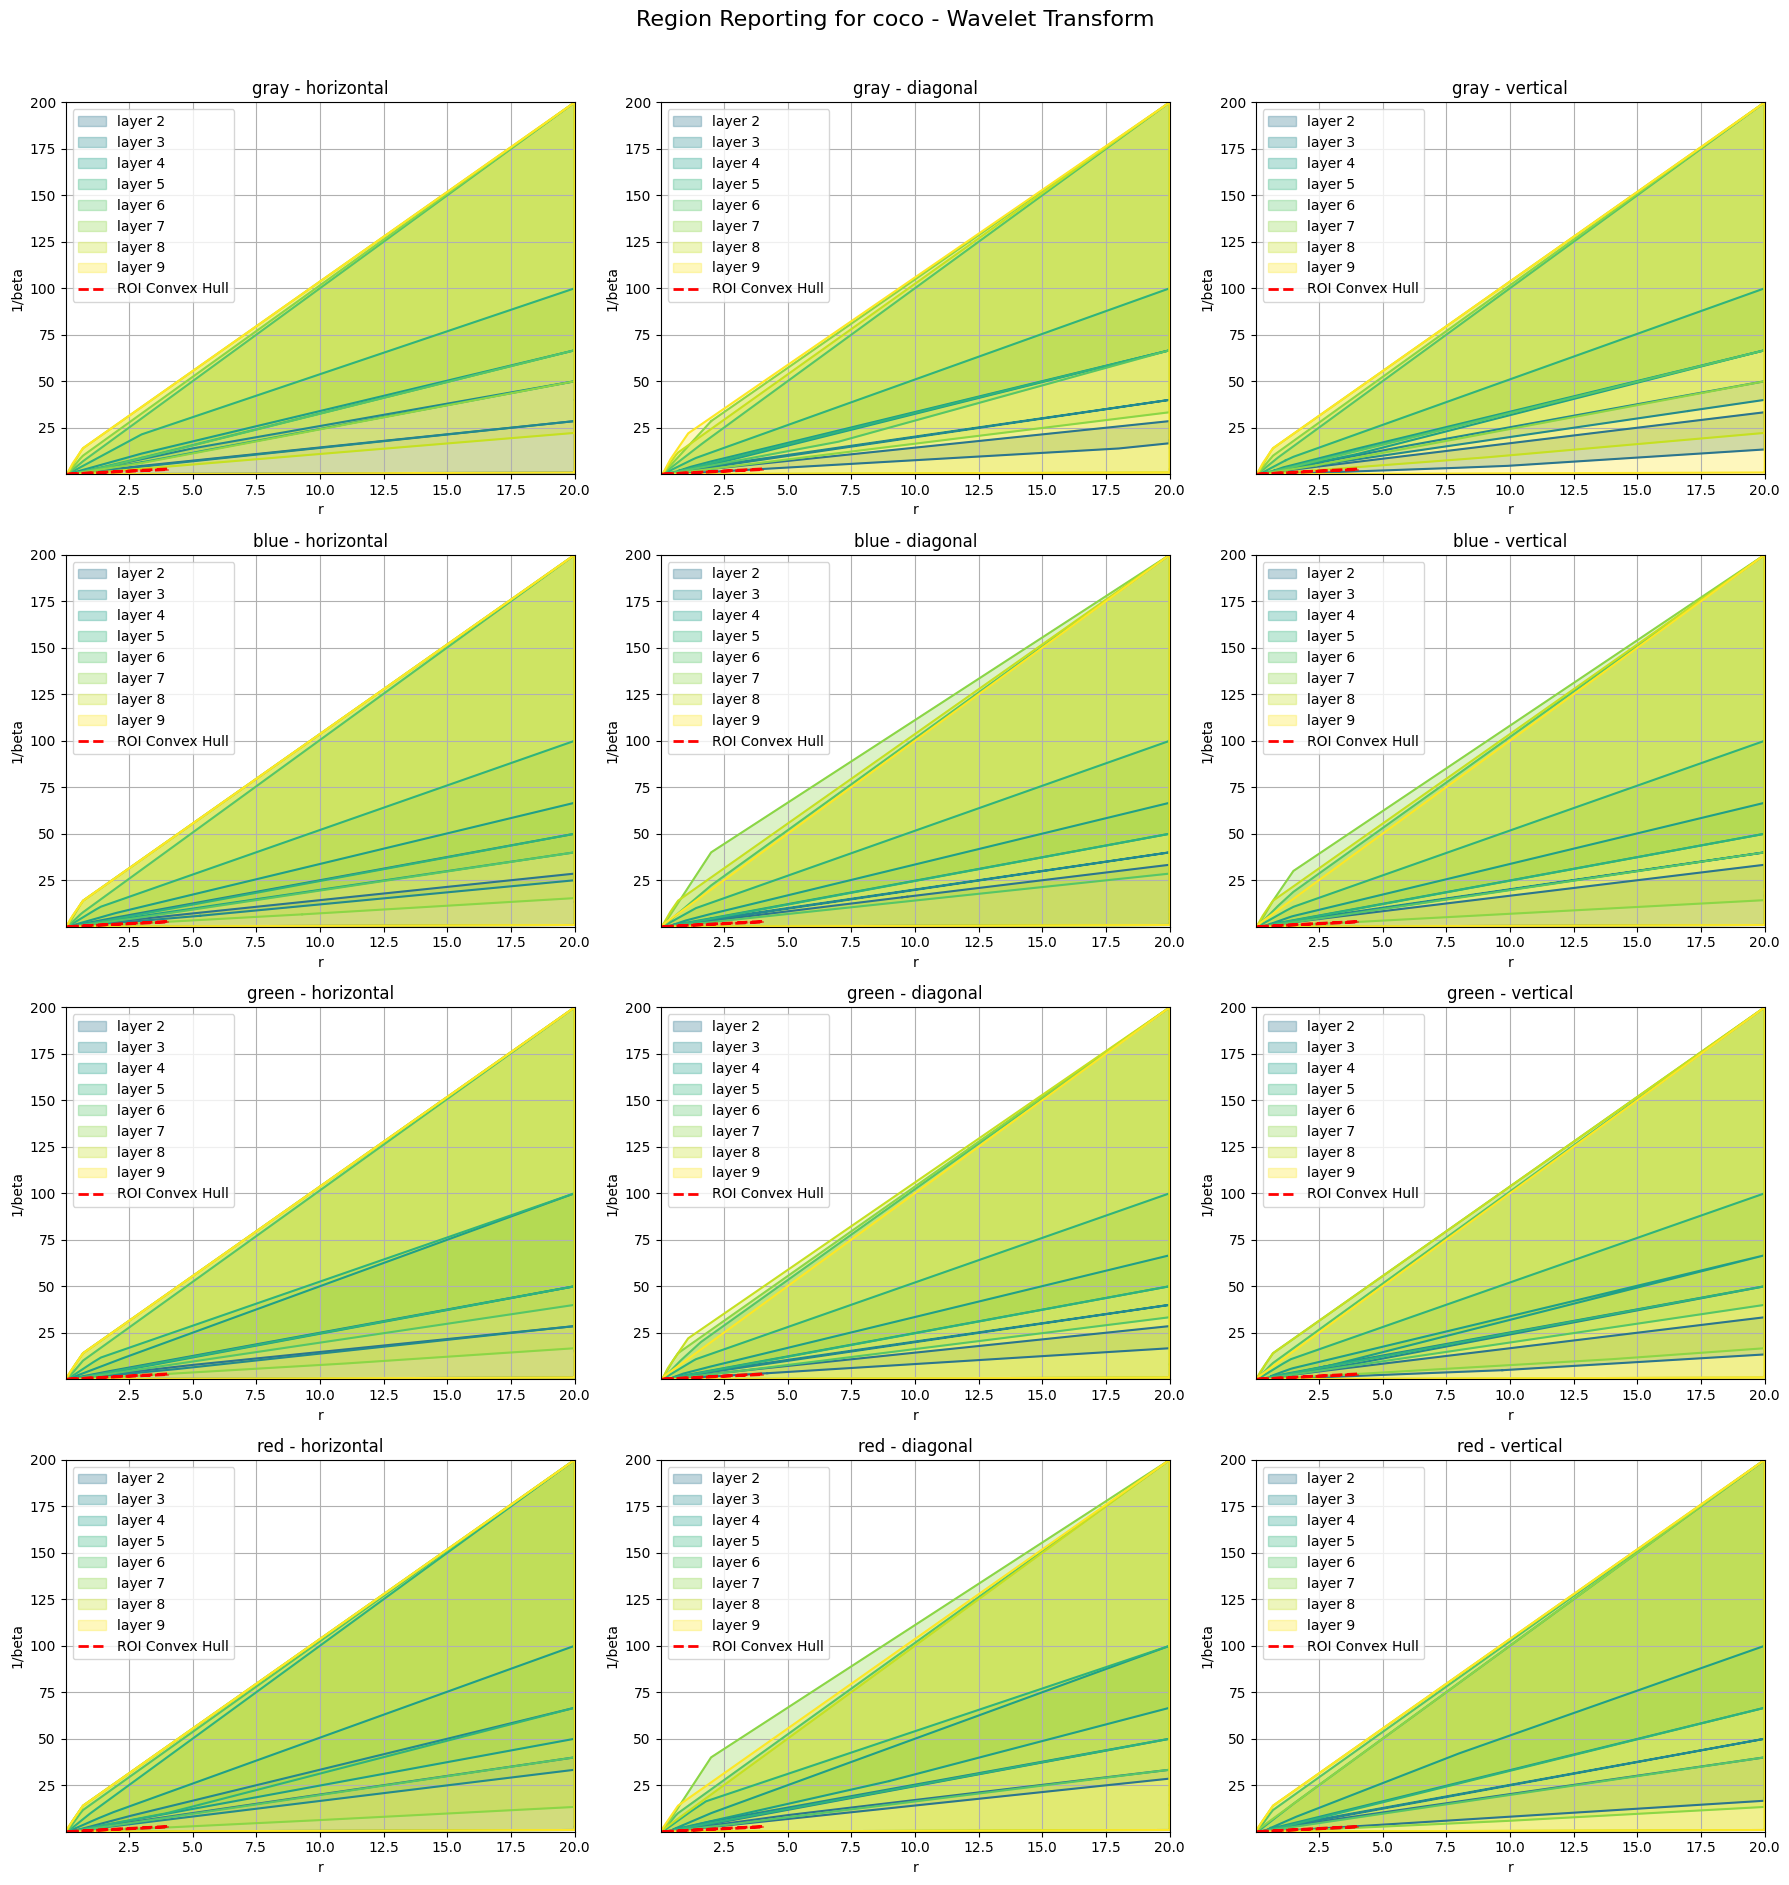

In [48]:
# Find global min/max for all hulls
all_points = np.concatenate([np.array(hull).reshape(-1, 2) for hull in all_hulls_df['hull']])
x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()

channels = all_hulls_df["CHANNEL"].unique()
directions = all_hulls_df["DIRECTION"].unique()

fig, axes = plt.subplots(len(channels), len(directions), figsize=(6 * len(directions), 5 * len(channels)), squeeze=False)

for i, channel in enumerate(channels):
    for j, direction in enumerate(directions):
        ax = axes[i, j]
        subset = all_hulls_df[(all_hulls_df["CHANNEL"] == channel) & (all_hulls_df["DIRECTION"] == direction)]
        if subset.empty:
            ax.set_title(f"{channel} - {direction}\n(No Data)")
            ax.axis('off')
            continue
        max_band = subset["BAND"].astype(int).max()
        colors = plt.cm.viridis(np.linspace(0.3, 1, max_band))
        for _, row in subset.iterrows():
            BAND = int(row['BAND'])
            hull = np.array(row['hull'])
            color = colors[BAND - 1]
            ax.fill(hull[:, 0], hull[:, 1], color=color, alpha=0.3, label=f'{kind} {BAND}')
            ax.plot(hull[:, 0], hull[:, 1], color=color)
            ax.plot([hull[-1, 0], hull[0, 0]], [hull[-1, 1], hull[0, 1]], color=color)

        #ADD ROI
        ax.plot(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], 'r--', lw=2, label='ROI Convex Hull')
        ax.fill(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], color='red', alpha=0.1)
        ax.plot([roi_points[roi_hull.vertices[-1], 0], roi_points[roi_hull.vertices[0], 0]],
                 [roi_points[roi_hull.vertices[-1], 1], roi_points[roi_hull.vertices[0], 1]],'r--', lw=2)

            
        ax.set_title(f"{channel} - {direction}")
        ax.set_xlabel('r')
        ax.set_ylabel('1/beta')
        ax.legend()
        ax.grid()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

plt.suptitle(f"Region Reporting for {DATA_SET} - Wavelet Transform", fontsize=16, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


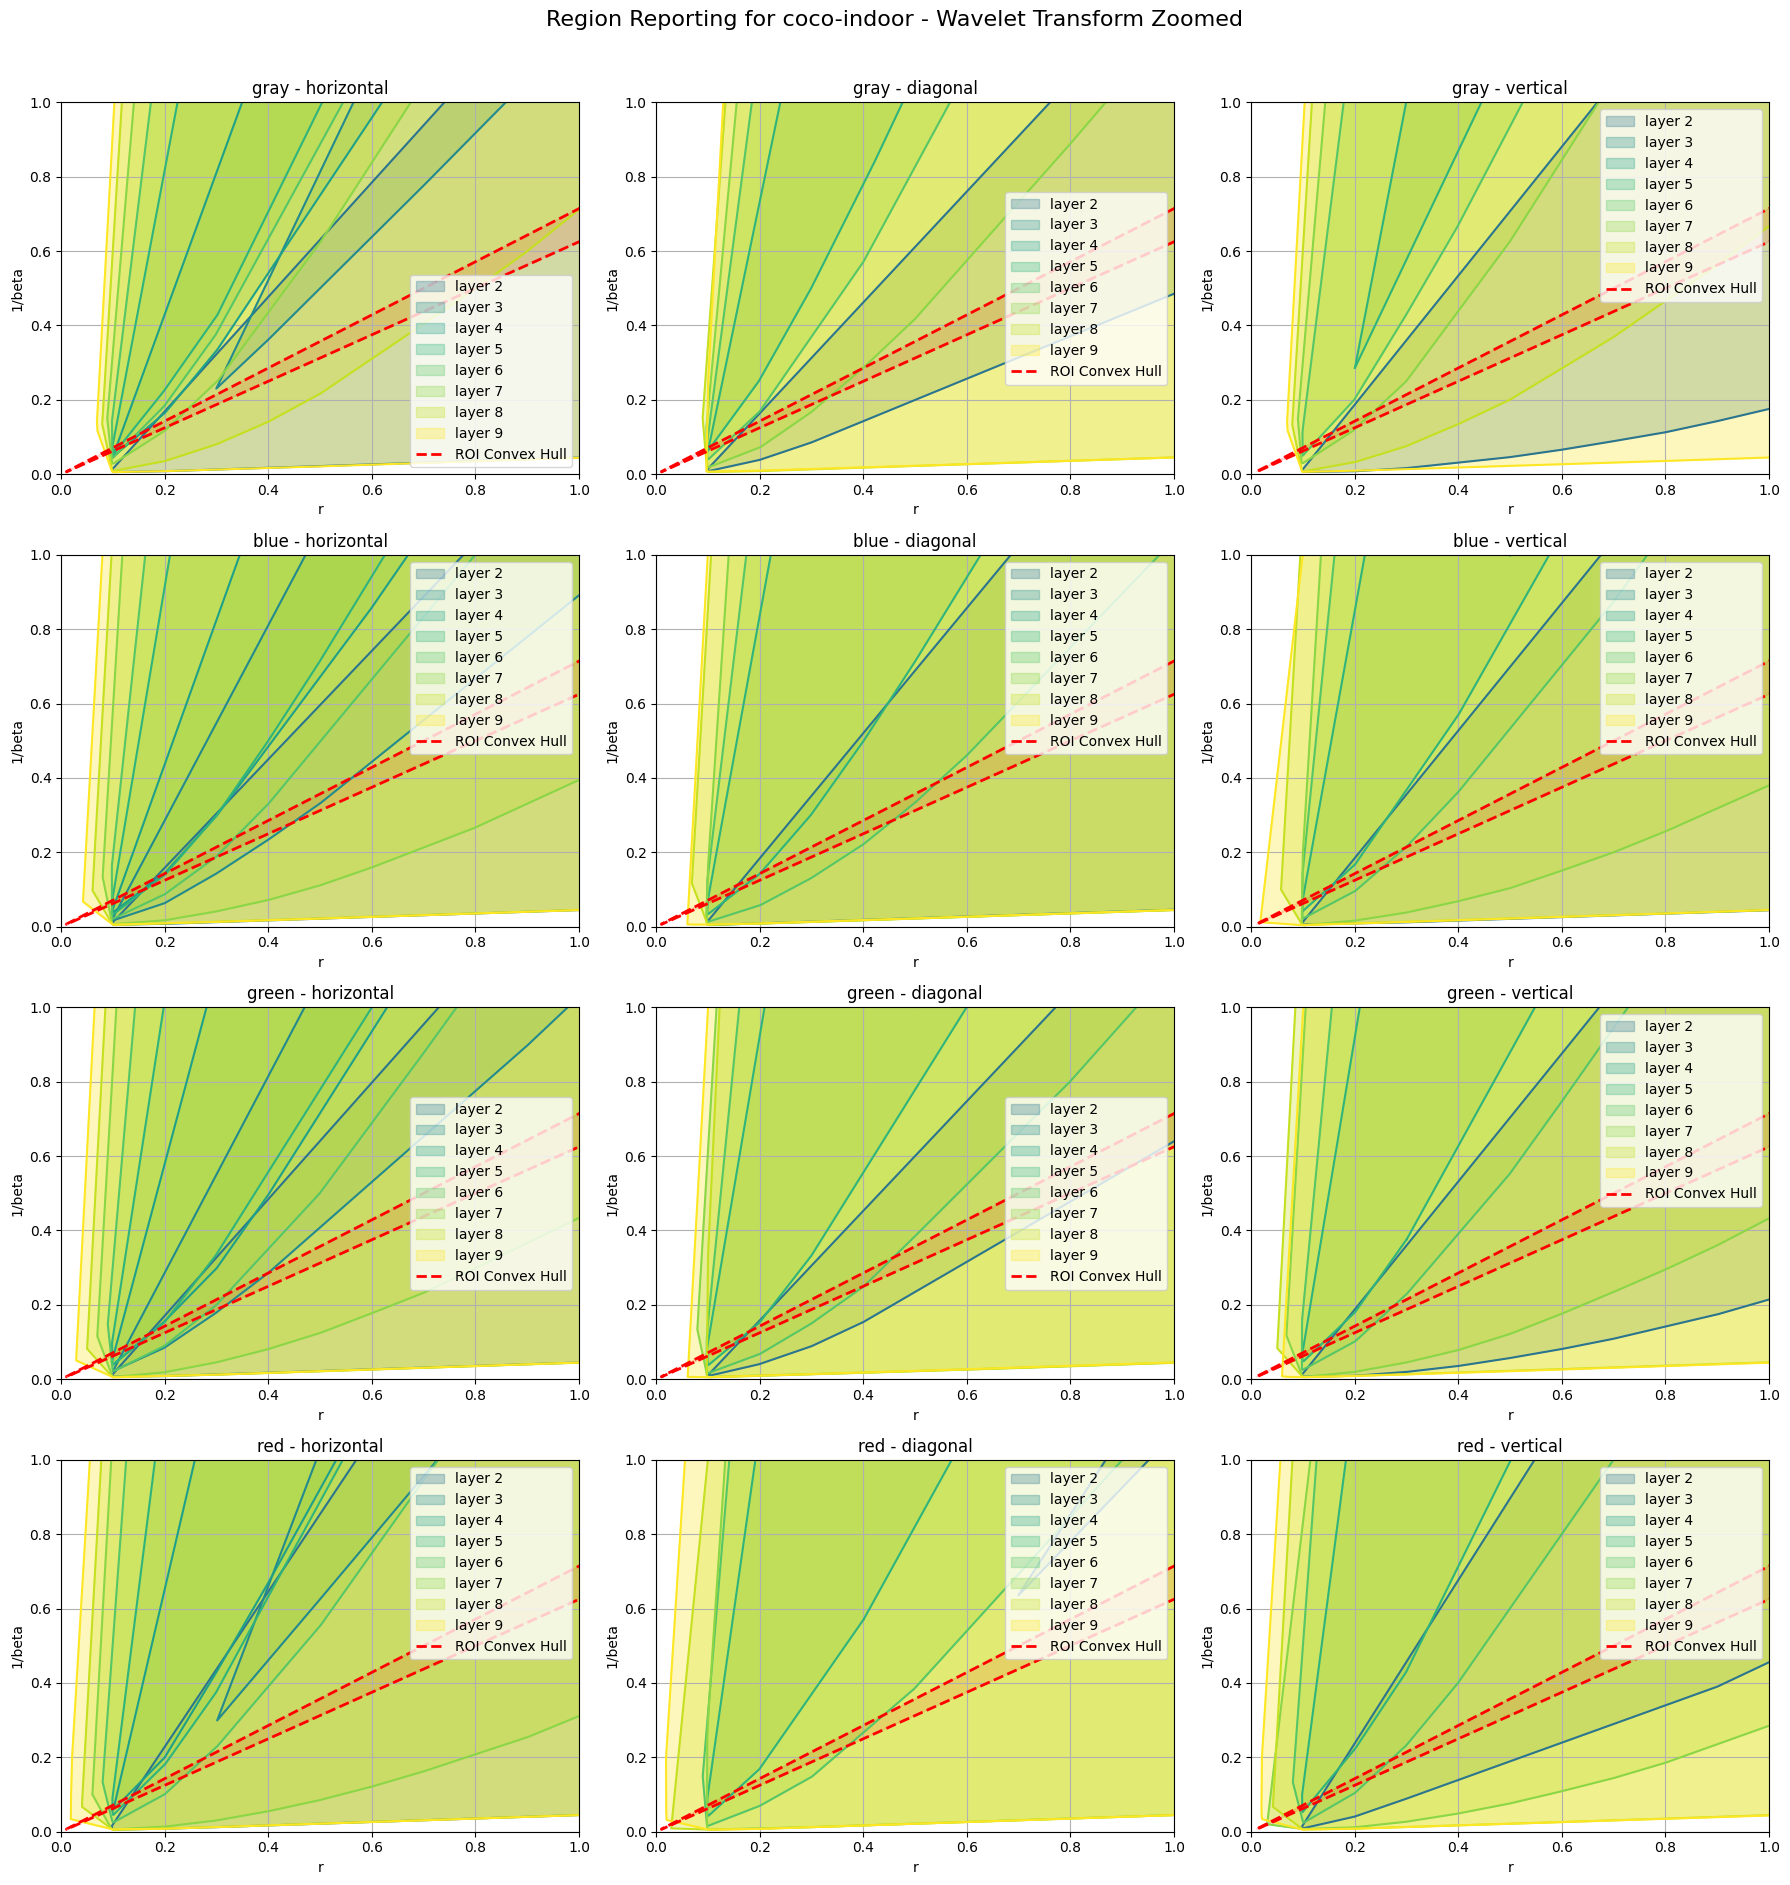

In [49]:
# Find global min/max for all hulls
all_points = np.concatenate([np.array(hull).reshape(-1, 2) for hull in all_hulls_df['hull']])
x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()

channels = all_hulls_df["CHANNEL"].unique()
directions = all_hulls_df["DIRECTION"].unique()

fig, axes = plt.subplots(len(channels), len(directions), figsize=(6 * len(directions), 5 * len(channels)), squeeze=False)

for i, channel in enumerate(channels):
    for j, direction in enumerate(directions):
        ax = axes[i, j]
        subset = all_hulls_df[(all_hulls_df["CHANNEL"] == channel) & (all_hulls_df["DIRECTION"] == direction)]
        if subset.empty:
            ax.set_title(f"{channel} - {direction}\n(No Data)")
            ax.axis('off')
            continue
        max_band = subset["BAND"].astype(int).max()
        colors = plt.cm.viridis(np.linspace(0.3, 1, max_band))
        for _, row in subset.iterrows():
            BAND = int(row['BAND'])
            hull = np.array(row['hull'])
            color = colors[BAND - 1]
            ax.fill(hull[:, 0], hull[:, 1], color=color, alpha=0.3, label=f'{kind} {BAND}')
            ax.plot(hull[:, 0], hull[:, 1], color=color)
            ax.plot([hull[-1, 0], hull[0, 0]], [hull[-1, 1], hull[0, 1]], color=color)
        
        #ADD ROI
        ax.plot(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], 'r--', lw=2, label='ROI Convex Hull')
        ax.fill(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], color='red', alpha=0.1)
        ax.plot([roi_points[roi_hull.vertices[-1], 0], roi_points[roi_hull.vertices[0], 0]],
                 [roi_points[roi_hull.vertices[-1], 1], roi_points[roi_hull.vertices[0], 1]],'r--', lw=2)

        
        
        ax.set_title(f"{channel} - {direction}")
        ax.set_xlabel('r')
        ax.set_ylabel('1/beta')
        ax.legend()
        ax.grid()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

plt.suptitle(f"Region Reporting for {DATA_SET}-{TYPE} - Wavelet Transform Zoomed", fontsize=16, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


## Outdoor

In [50]:
DATA_SET = "coco"
TYPE = "outdoor"

In [51]:
kind = "layer"
all_hulls_df = pd.DataFrame(columns=["BAND", "hull", "CHANNEL", "DIRECTION"])
for DIRECTION in ["horizontal", "diagonal", "vertical"]:
    for CHANNEL in ["gray", "blue", "green", "red"]:
        DATA_NAME = f'{DATA_SET}-{TYPE}' 
        TRANSFORM = f'wavelet-{DIRECTION}'
        CHANNEL = CHANNEL

        path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
        
        if CHANNEL:
            path_list.append(CHANNEL)
        print(path_list)
        ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
        CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)


        DICT_PATH = os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle")
        MASTERDF_DIR = os.path.join(CWD, "CSVs", "master_df.csv")
        rEtaKsstats_dict = pd.read_pickle(DICT_PATH)
        master_df = pd.read_csv(MASTERDF_DIR)
        master_df = master_df.set_index("layer")
        master_df
        hulls_df = region_reporting(rEtaKsstats_dict, master_df, layer = "all", MULT =1.2, kind = kind, plots=False, plot_name = "-".join(path_list))
        hulls_df["CHANNEL"] = CHANNEL
        hulls_df["DIRECTION"] = DIRECTION
        all_hulls_df = pd.concat([all_hulls_df, hulls_df], ignore_index=True)
all_hulls_df = all_hulls_df.reset_index(drop=True)
all_hulls_df

['coco', 'outdoor', 'wavelet', 'horizontal', 'gray']
['r_optimize', 'eta_optimize', 'ksstat_exclude_plus0']
0.09704512385869703 0.0302381764308697
Layer 2: None Passed
Rational Function Parameters: a=0.6638644841999858, b=6.413965410641175, c=0.6577741880735108, d=-0.2184661448891198, e=24.018361519057983
Quadratic Function Parameters: a=0.03844310924684635, b=0.21346003614076448, c=0.0931084786571934
Linear Function Parameters: m=0.6856748624622926, c=-0.8346783339151684
['r_optimize', 'eta_optimize', 'ksstat_exclude_plus0']
0.0756301318038088 0.015140345828992
Layer 3: None Passed
Rational Function Parameters: a=1.3258678438225895, b=0.7485084504814407, c=-0.13884436828850458, d=0.801668774372161, e=0.4184348562395144
Quadratic Function Parameters: a=-0.0009789359222733829, b=1.6812664958468357, c=-0.101350535164064
Linear Function Parameters: m=1.6676450108278633, c=-0.08000646272609191
['r_optimize', 'eta_optimize', 'ksstat_exclude_plus0']
0.04966333025090923 0.0075754266424887
Lay

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/plotting.py:775: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_linear, _ = curve_fit(linear_func, test2["r"], test2["1/beta"], maxfev=10000)


Rational Function Parameters: a=4.504806507659676, b=3.2853266684889126, c=3.609766548569726e-07, d=1.801922600077831, e=1.3141307143784515
Quadratic Function Parameters: a=1.889203018562746e-09, b=2.499999962130503, c=1.226407275680728e-07
Linear Function Parameters: m=2.500000000109426, c=-9.975964498920575e-10
['r_optimize', 'eta_optimize', 'ksstat_exclude_plus0']
0.02456380857427698 0.0075754266424887
Layer 4: None Passed
Rational Function Parameters: a=43.54342634057779, b=-10.272890737381127, c=-3.0766477923908977, d=13.138453302860876, e=-3.9436346707971657
Quadratic Function Parameters: a=-0.0006301074945980653, b=3.3427513538976266, c=-0.006617097542431073
Linear Function Parameters: m=3.3339188896511884, c=0.007256196284417871
['r_optimize', 'eta_optimize', 'ksstat_exclude_plus0']
0.05345999999999971 0.0037890191408675
Layer 5: None Passed
Rational Function Parameters: a=10.210455922141142, b=9.627611997042077, c=-2.2446361279359817, d=2.468378607326347, e=2.0618950620878236


BAND                                               hull CHANNEL   DIRECTION
0     2  [[20.0011480815897, 28.57095707172692], [19.99...    gray  horizontal
1     3  [[20.001459334604125, 22.221374301374848], [20...    gray  horizontal
2     4  [[0.501261730875537, 1.0014201037131714], [0.5...    gray  horizontal
3     5  [[19.999333441018425, 66.66657749152309], [20....    gray  horizontal
4     6  [[20.0017343165623, 66.66420685335757], [20.00...    gray  horizontal
..  ...                                                ...     ...         ...
91    5  [[19.999826535973188, 100.00172278594522], [1....     red    vertical
92    6  [[20.000923057688297, 199.99864895630338], [1....     red    vertical
93    7  [[20.00186519478738, 28.572063680189235], [20....     red    vertical
94    8  [[20.002140470926314, 2.666021537044225], [19....     red    vertical
95    9  [[19.99863026819596, 199.9994968984121], [0.70...     red    vertical

[96 rows x 4 columns]

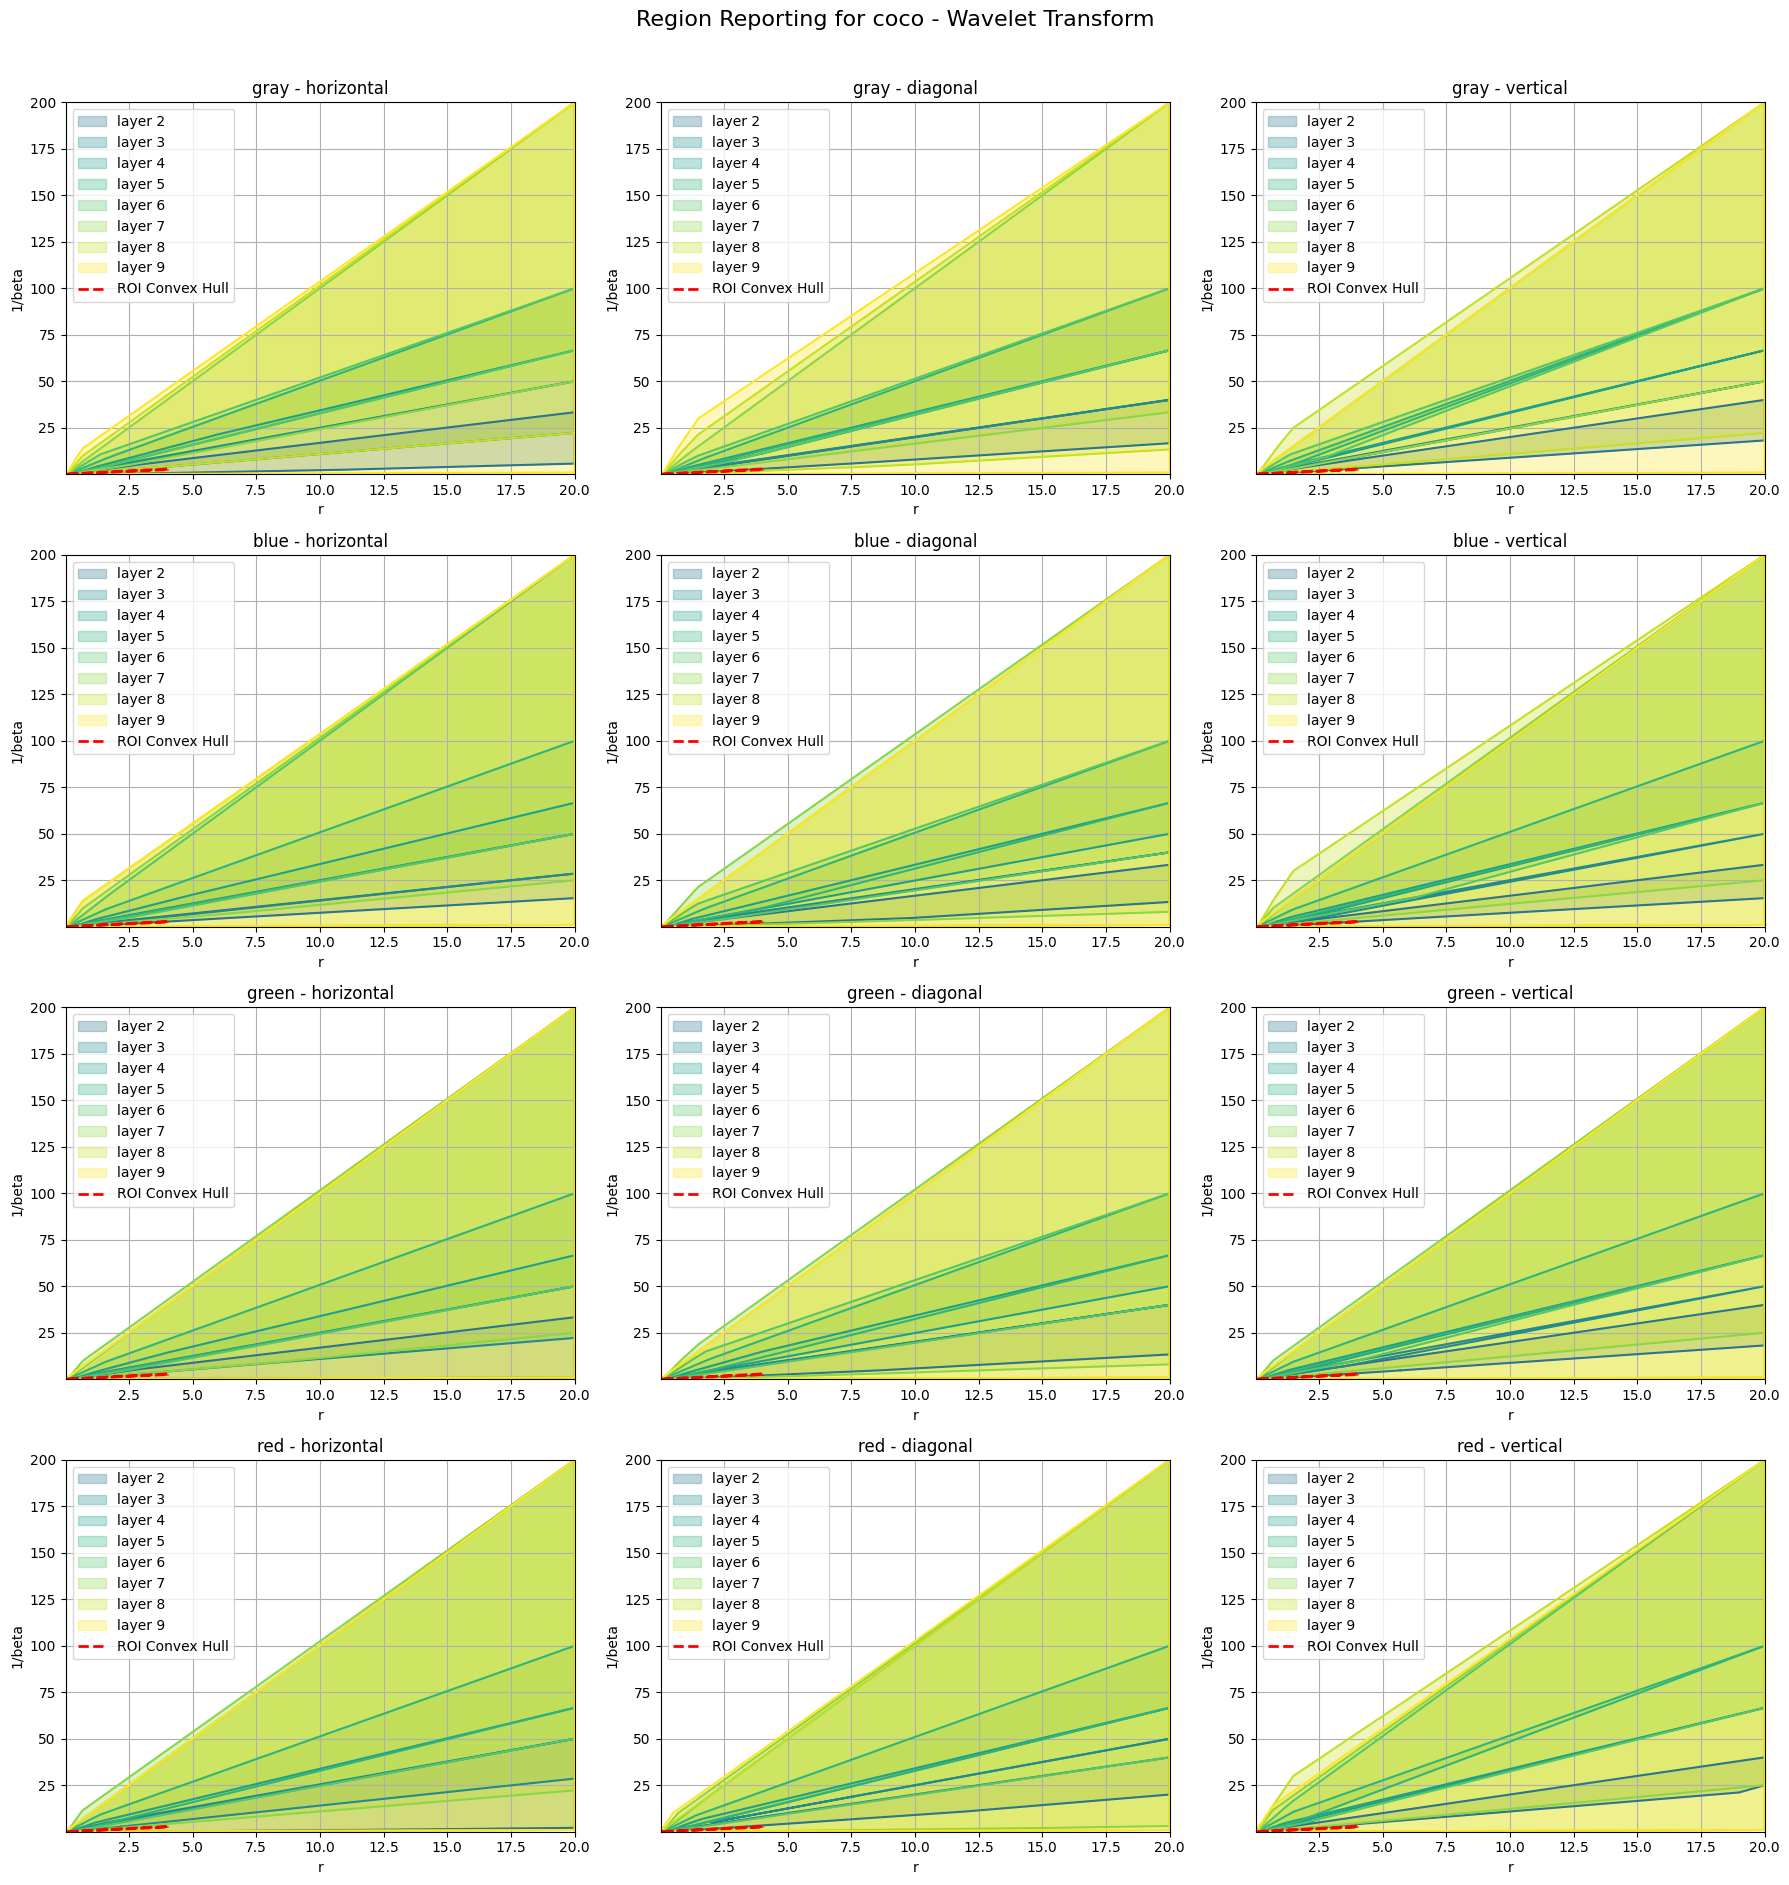

In [52]:
# Find global min/max for all hulls
all_points = np.concatenate([np.array(hull).reshape(-1, 2) for hull in all_hulls_df['hull']])
x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()

channels = all_hulls_df["CHANNEL"].unique()
directions = all_hulls_df["DIRECTION"].unique()

fig, axes = plt.subplots(len(channels), len(directions), figsize=(6 * len(directions), 5 * len(channels)), squeeze=False)

for i, channel in enumerate(channels):
    for j, direction in enumerate(directions):
        ax = axes[i, j]
        subset = all_hulls_df[(all_hulls_df["CHANNEL"] == channel) & (all_hulls_df["DIRECTION"] == direction)]
        if subset.empty:
            ax.set_title(f"{channel} - {direction}\n(No Data)")
            ax.axis('off')
            continue
        max_band = subset["BAND"].astype(int).max()
        colors = plt.cm.viridis(np.linspace(0.3, 1, max_band))
        for _, row in subset.iterrows():
            BAND = int(row['BAND'])
            hull = np.array(row['hull'])
            color = colors[BAND - 1]
            ax.fill(hull[:, 0], hull[:, 1], color=color, alpha=0.3, label=f'{kind} {BAND}')
            ax.plot(hull[:, 0], hull[:, 1], color=color)
            ax.plot([hull[-1, 0], hull[0, 0]], [hull[-1, 1], hull[0, 1]], color=color)
        
        #ADD ROI
        ax.plot(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], 'r--', lw=2, label='ROI Convex Hull')
        ax.fill(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], color='red', alpha=0.1)
        ax.plot([roi_points[roi_hull.vertices[-1], 0], roi_points[roi_hull.vertices[0], 0]],
                 [roi_points[roi_hull.vertices[-1], 1], roi_points[roi_hull.vertices[0], 1]],'r--', lw=2)


        ax.set_title(f"{channel} - {direction}")
        ax.set_xlabel('r')
        ax.set_ylabel('1/beta')
        ax.legend()
        ax.grid()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

plt.suptitle(f"Region Reporting for {DATA_SET} - Wavelet Transform", fontsize=16, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


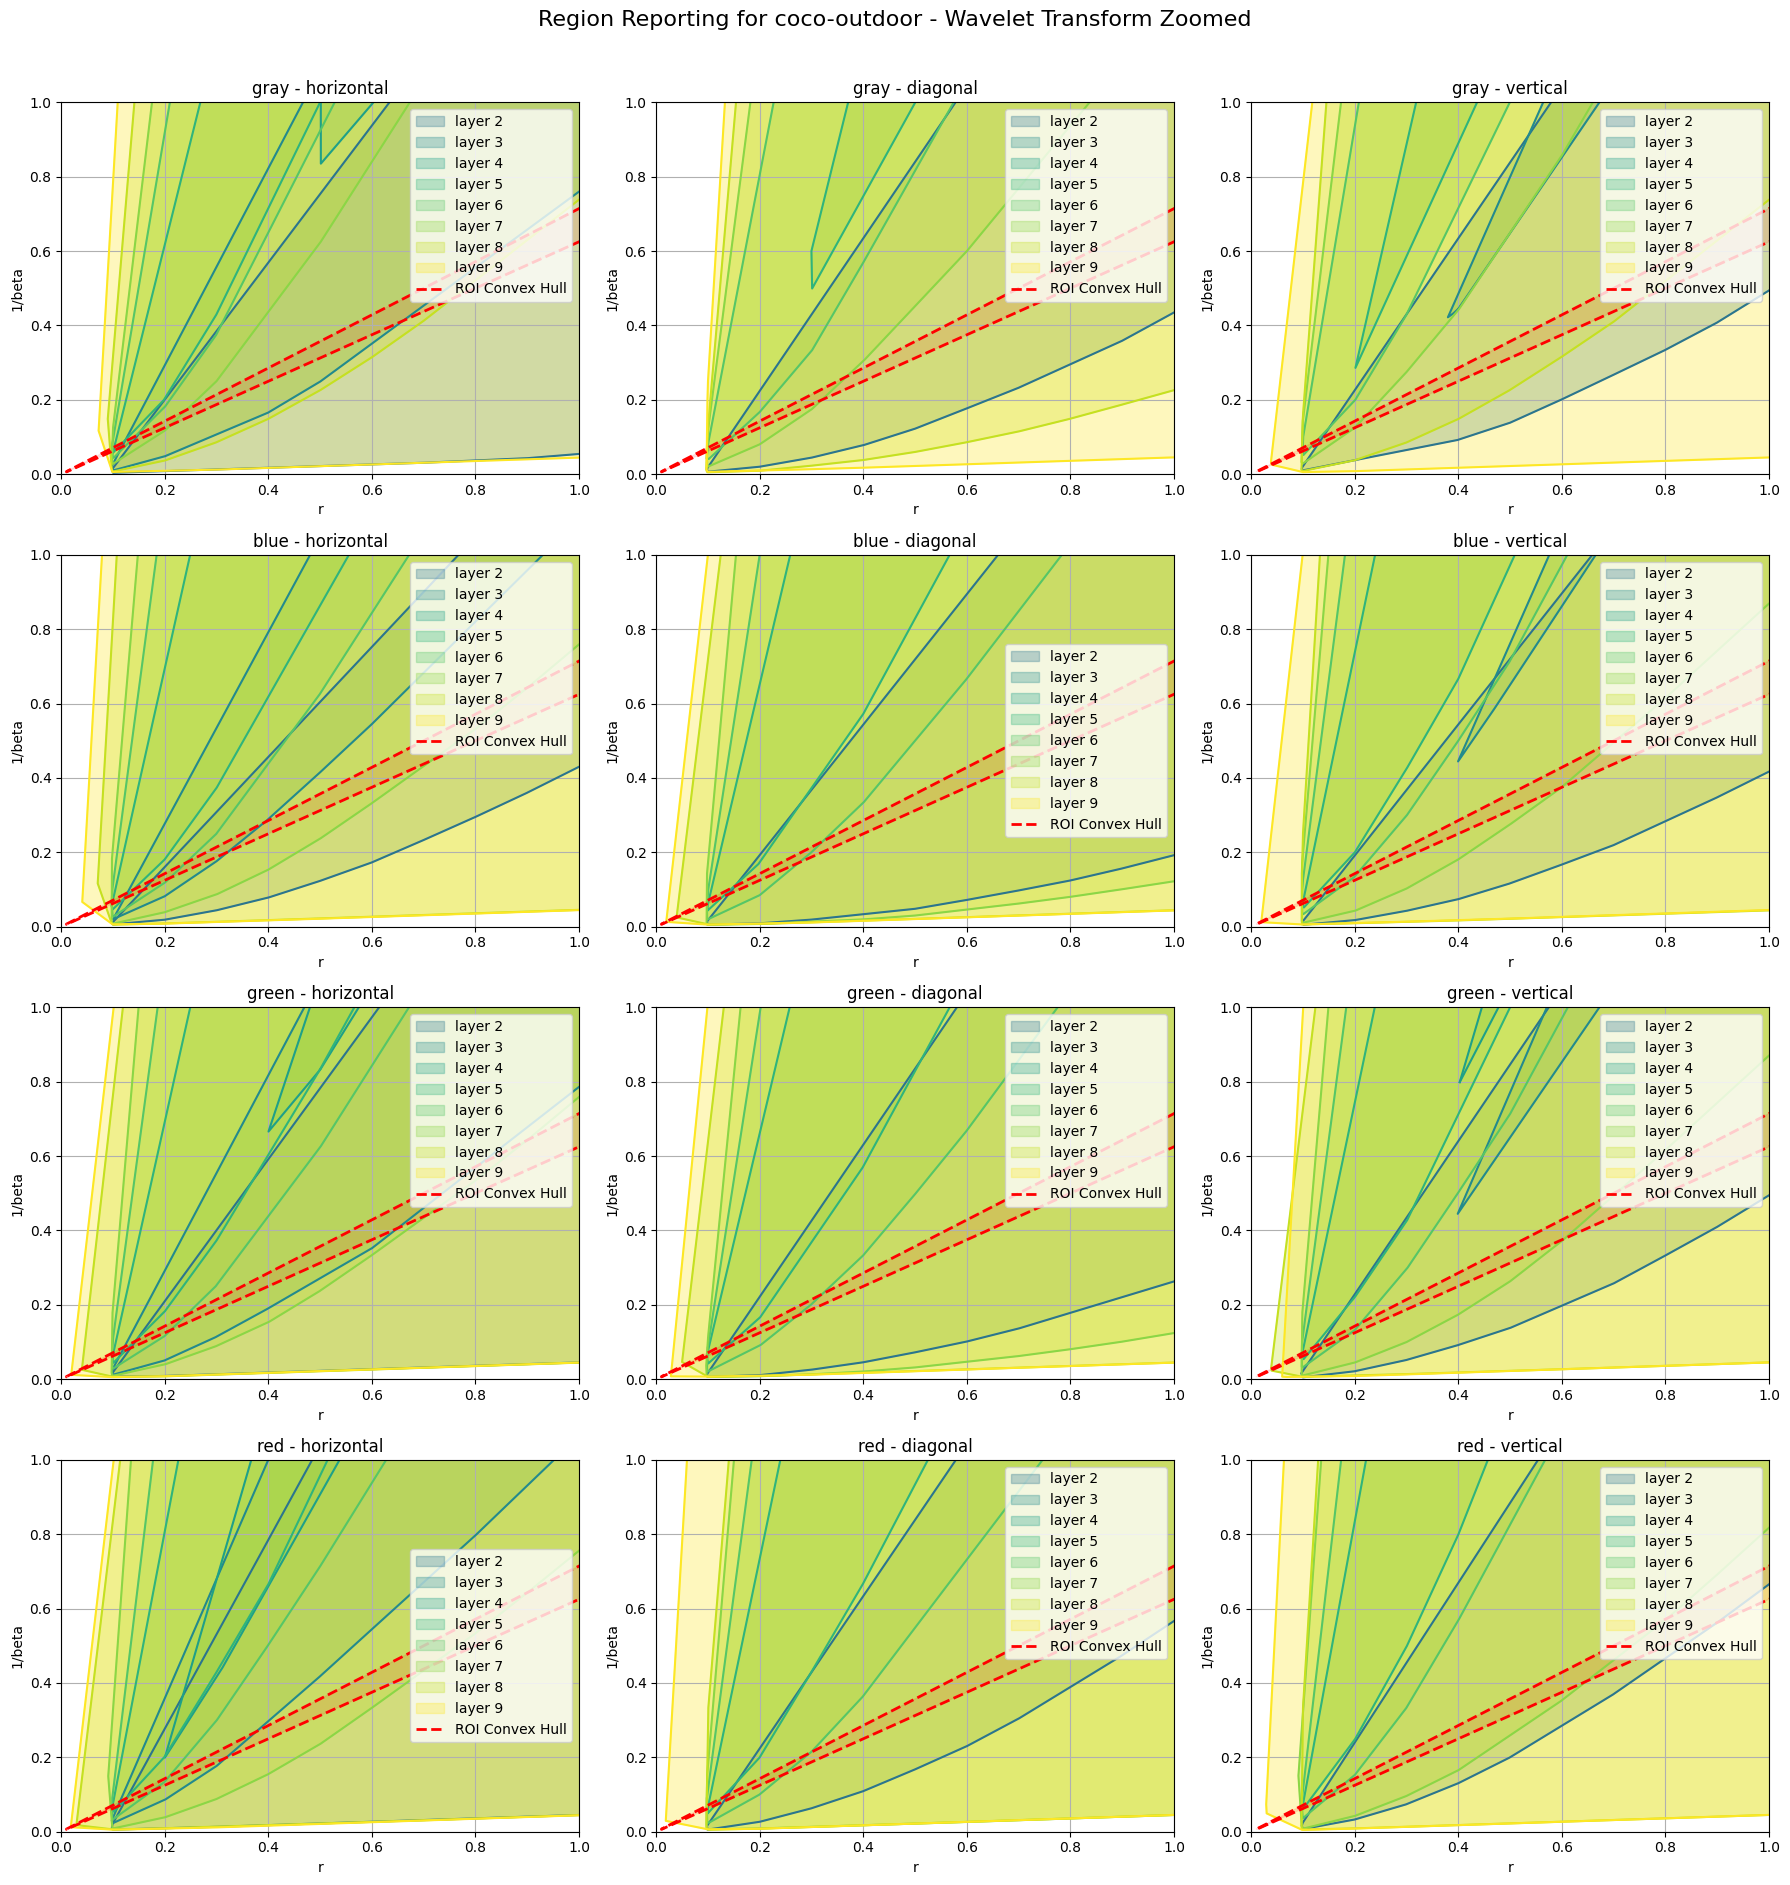

In [53]:
# Find global min/max for all hulls
all_points = np.concatenate([np.array(hull).reshape(-1, 2) for hull in all_hulls_df['hull']])
x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()

channels = all_hulls_df["CHANNEL"].unique()
directions = all_hulls_df["DIRECTION"].unique()

fig, axes = plt.subplots(len(channels), len(directions), figsize=(6 * len(directions), 5 * len(channels)), squeeze=False)

for i, channel in enumerate(channels):
    for j, direction in enumerate(directions):
        ax = axes[i, j]
        subset = all_hulls_df[(all_hulls_df["CHANNEL"] == channel) & (all_hulls_df["DIRECTION"] == direction)]
        if subset.empty:
            ax.set_title(f"{channel} - {direction}\n(No Data)")
            ax.axis('off')
            continue
        max_band = subset["BAND"].astype(int).max()
        colors = plt.cm.viridis(np.linspace(0.3, 1, max_band))
        for _, row in subset.iterrows():
            BAND = int(row['BAND'])
            hull = np.array(row['hull'])
            color = colors[BAND - 1]
            ax.fill(hull[:, 0], hull[:, 1], color=color, alpha=0.3, label=f'{kind} {BAND}')
            ax.plot(hull[:, 0], hull[:, 1], color=color)
            ax.plot([hull[-1, 0], hull[0, 0]], [hull[-1, 1], hull[0, 1]], color=color)
        
        #ADD ROI
        ax.plot(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], 'r--', lw=2, label='ROI Convex Hull')
        ax.fill(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], color='red', alpha=0.1)
        ax.plot([roi_points[roi_hull.vertices[-1], 0], roi_points[roi_hull.vertices[0], 0]],
                 [roi_points[roi_hull.vertices[-1], 1], roi_points[roi_hull.vertices[0], 1]],'r--', lw=2)

        
        ax.set_title(f"{channel} - {direction}")
        ax.set_xlabel('r')
        ax.set_ylabel('1/beta')
        ax.legend()
        ax.grid()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

plt.suptitle(f"Region Reporting for {DATA_SET}-{TYPE} - Wavelet Transform Zoomed", fontsize=16, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


# SegmentAnything

In [54]:
DATA_SET = "segmentAnything"

In [55]:
kind = "layer"
all_hulls_df = pd.DataFrame(columns=["BAND", "hull", "CHANNEL", "DIRECTION"])
for DIRECTION in ["horizontal", "diagonal", "vertical"]:
    for CHANNEL in ["gray", "blue", "green", "red"]:
        DATA_NAME = f'{DATA_SET}-full' 
        TRANSFORM = f'wavelet-{DIRECTION}'
        CHANNEL = CHANNEL

        path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
        
        if CHANNEL:
            path_list.append(CHANNEL)
        print(path_list)
        ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
        CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)


        DICT_PATH = os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle")
        MASTERDF_DIR = os.path.join(CWD, "CSVs", "master_df.csv")
        rEtaKsstats_dict = pd.read_pickle(DICT_PATH)
        master_df = pd.read_csv(MASTERDF_DIR)
        master_df = master_df.set_index("layer")
        master_df
        hulls_df = region_reporting(rEtaKsstats_dict, master_df, layer = "all", MULT =1.2, kind = kind, plots=False, plot_name = "-".join(path_list))
        hulls_df["CHANNEL"] = CHANNEL
        hulls_df["DIRECTION"] = DIRECTION
        all_hulls_df = pd.concat([all_hulls_df, hulls_df], ignore_index=True)
all_hulls_df = all_hulls_df.reset_index(drop=True)
all_hulls_df

['segmentAnything', 'full', 'wavelet', 'horizontal', 'gray']
['r_optimize', 'eta_optimize', 'ksstat_exclude_plus0']
0.0793233171151628 0.0161257775072161
Layer 2: None Passed
Rational Function Parameters: a=37.45156921758058, b=355.98044952121205, c=1416.908239524124, d=-50.21295461993172, e=3533.2464673271224
Quadratic Function Parameters: a=0.018283260029062515, b=0.06327600831241276, c=0.46080223433083
Linear Function Parameters: m=0.29970189926828905, c=-0.07528784763115837
['r_optimize', 'eta_optimize', 'ksstat_exclude_minus25']
0.05204812115610959 0.0080688542119711
Layer 3: None Passed
Rational Function Parameters: a=9.388373108550482, b=12.558777617782942, c=-2.416424536653565, d=5.581992071108579, e=6.651446889488375
Quadratic Function Parameters: a=-0.002077254359806213, b=1.7395668395618933, c=-0.14406228910794439
Linear Function Parameters: m=1.7092838141888855, c=-0.08571639529411423
['r_optimize', 'eta_optimize', 'ksstat_exclude_plus0']
0.03708058283316751 0.0040359092726

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/plotting.py:772: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_quadratic, _ = curve_fit(quadratic_func, test2["r"], test2["1/beta"], maxfev=10000)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/plotting.py:775: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_linear, _ = curve_fit(linear_func, test2["r"], test2["1/beta"], maxfev=10000)


Rational Function Parameters: a=-0.9673722202853241, b=10.12761634729021, c=0.4686682287513177, d=-0.2928422462685778, e=3.0772212633218574
Quadratic Function Parameters: a=0.0011025695822458603, b=3.3038492063195597, c=0.1512872588863987
Linear Function Parameters: m=3.3139121015202644, c=0.1356427094589613
['r_optimize', 'eta_optimize', 'ksstat_exclude_plus0']
0.04436399999999967 0.0010092542162957
Layer 6: None Passed
Rational Function Parameters: a=0.45698981826065754, b=25.7619751947896, c=-3.1599427210815785, d=0.12493290591698314, e=5.872292514328104
Quadratic Function Parameters: a=-0.009497741912045221, b=4.361037697632223, c=-0.4892745962556784
Linear Function Parameters: m=4.207414566413078, c=-0.06855000404014744
['r_optimize', 'eta_optimize', 'ksstat_exclude_plus0']
0.08756399999999971 0.0005046501409454
Layer 7: None Passed
Rational Function Parameters: a=-0.19754832462751906, b=15.174765309010192, c=-2.748180057528227, d=-0.034148396388050686, e=3.792114691789206
Quadrat

BAND                                               hull CHANNEL  \
0      2  [[20.000039961705266, 33.33295780872772], [2.0...    gray   
1      3  [[20.001357603745298, 33.33456350289098], [20....    gray   
2      4  [[0.39945215601565515, 0.57110236502511], [0.4...    gray   
3      5  [[20.001380621970362, 66.66669500353936], [3.0...    gray   
4      6  [[1.8994500364751497, 5.5900659225526725], [19...    gray   
..   ...                                                ...     ...   
103    6  [[20.00144043126285, 99.99989510893187], [8.00...     red   
104    7  [[1.9992162952213568, 4.998419003338525], [19....     red   
105    8  [[20.001534671727942, 33.334440732581314], [20...     red   
106    9  [[20.002301290774273, 2.3532140954199776], [20...     red   
107   10  [[20.00168271461157, 19.999307335365945], [19....     red   

      DIRECTION  
0    horizontal  
1    horizontal  
2    horizontal  
3    horizontal  
4    horizontal  
..          ...  
103    vertical  
104    vertical  
105    vertical  
106    vertical  
107    vertical  

[108 rows x 4 columns]

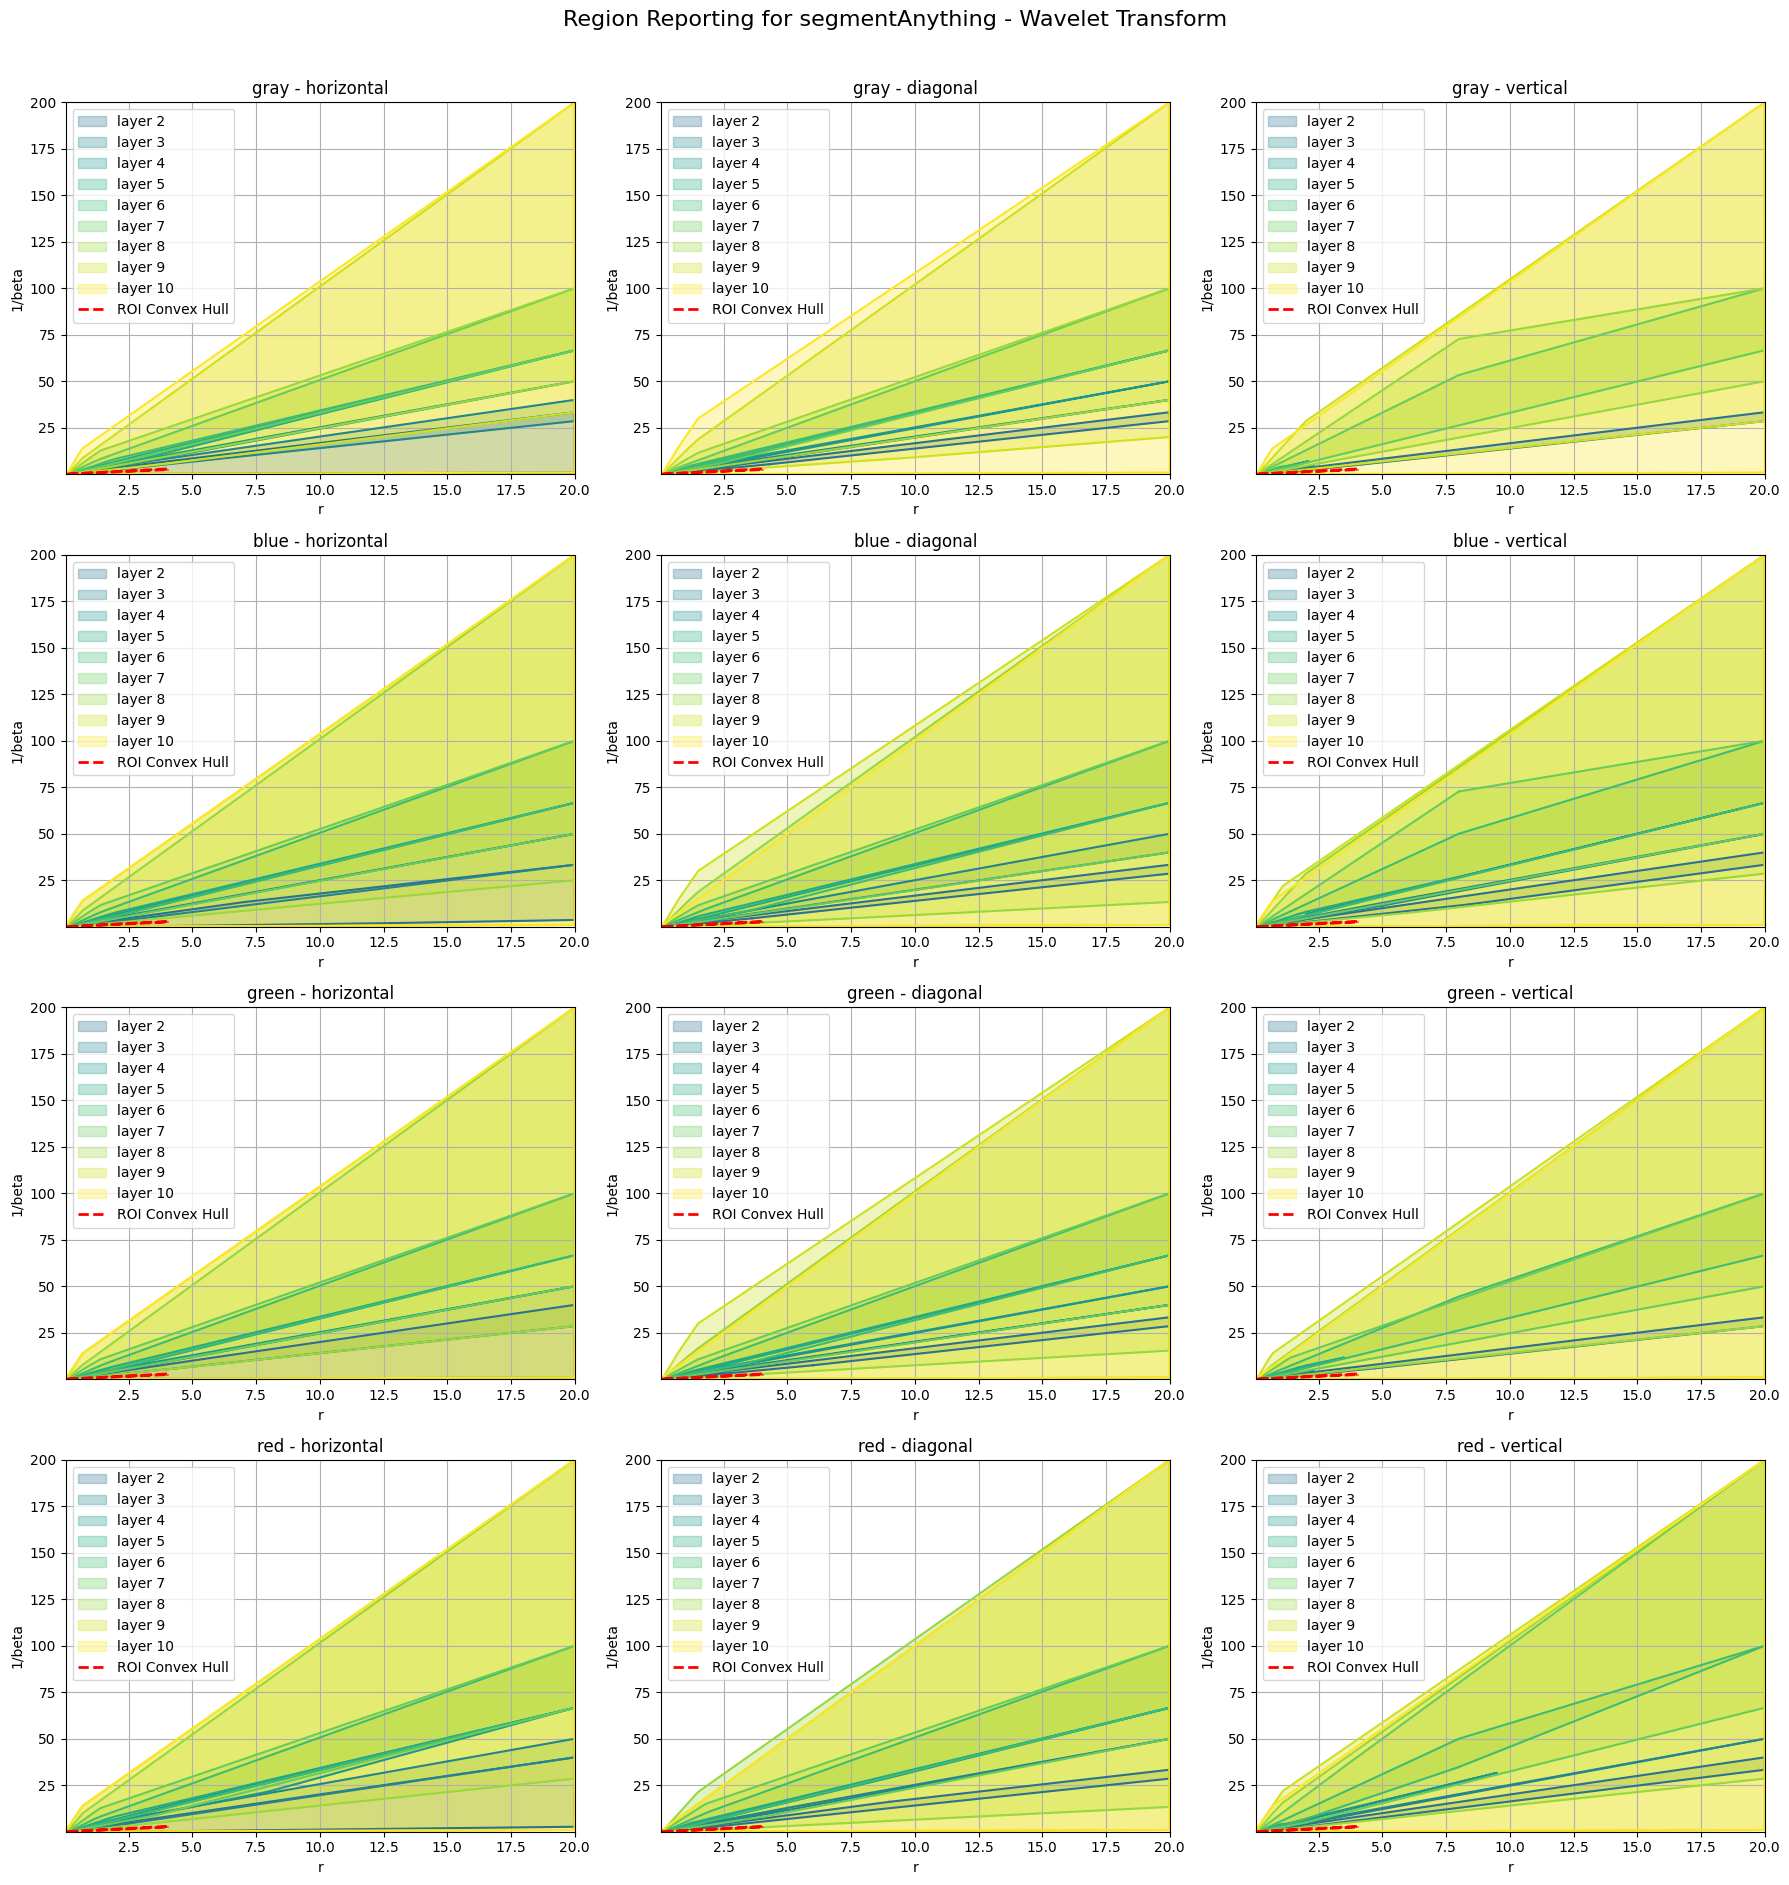

In [56]:
# Find global min/max for all hulls
all_points = np.concatenate([np.array(hull).reshape(-1, 2) for hull in all_hulls_df['hull']])
x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()

channels = all_hulls_df["CHANNEL"].unique()
directions = all_hulls_df["DIRECTION"].unique()

fig, axes = plt.subplots(len(channels), len(directions), figsize=(6 * len(directions), 5 * len(channels)), squeeze=False)

for i, channel in enumerate(channels):
    for j, direction in enumerate(directions):
        ax = axes[i, j]
        subset = all_hulls_df[(all_hulls_df["CHANNEL"] == channel) & (all_hulls_df["DIRECTION"] == direction)]
        if subset.empty:
            ax.set_title(f"{channel} - {direction}\n(No Data)")
            ax.axis('off')
            continue
        max_band = subset["BAND"].astype(int).max()
        colors = plt.cm.viridis(np.linspace(0.3, 1, max_band))
        for _, row in subset.iterrows():
            BAND = int(row['BAND'])
            hull = np.array(row['hull'])
            color = colors[BAND - 1]
            ax.fill(hull[:, 0], hull[:, 1], color=color, alpha=0.3, label=f'{kind} {BAND}')
            ax.plot(hull[:, 0], hull[:, 1], color=color)
            ax.plot([hull[-1, 0], hull[0, 0]], [hull[-1, 1], hull[0, 1]], color=color)
        
        #ADD ROI
        ax.plot(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], 'r--', lw=2, label='ROI Convex Hull')
        ax.fill(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], color='red', alpha=0.1)
        ax.plot([roi_points[roi_hull.vertices[-1], 0], roi_points[roi_hull.vertices[0], 0]],
                 [roi_points[roi_hull.vertices[-1], 1], roi_points[roi_hull.vertices[0], 1]],'r--', lw=2)

        ax.set_title(f"{channel} - {direction}")
        ax.set_xlabel('r')
        ax.set_ylabel('1/beta')
        ax.legend()
        ax.grid()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

plt.suptitle(f"Region Reporting for {DATA_SET} - Wavelet Transform", fontsize=16, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


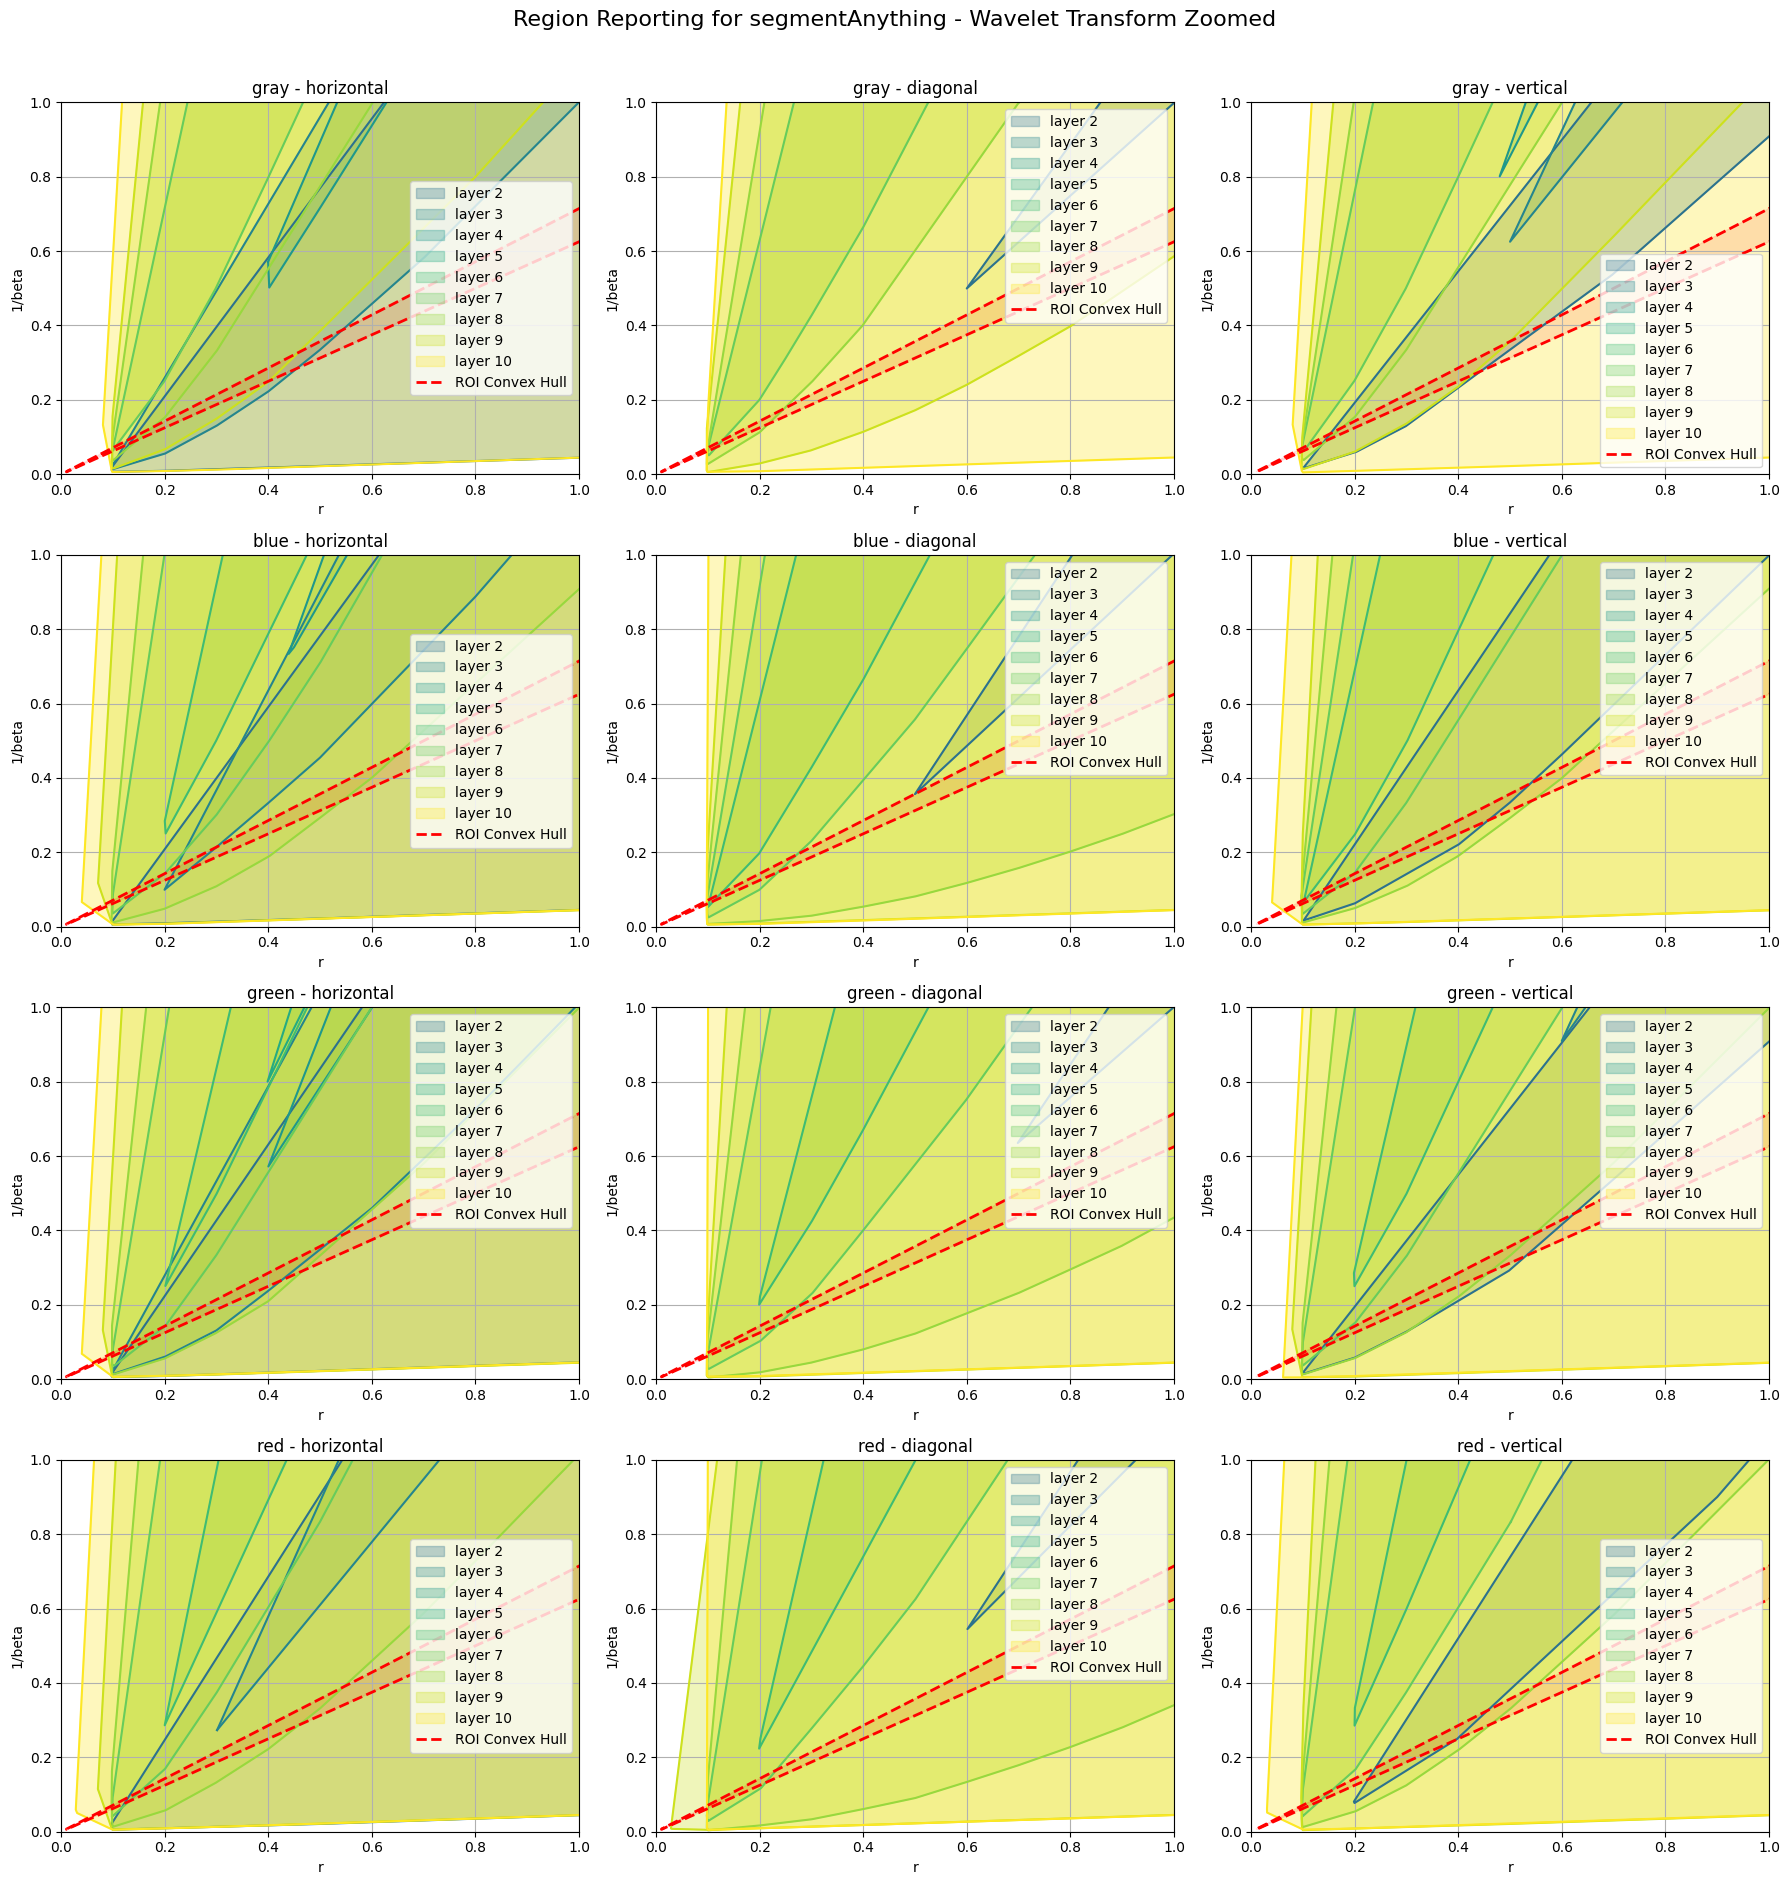

In [57]:
# Find global min/max for all hulls
all_points = np.concatenate([np.array(hull).reshape(-1, 2) for hull in all_hulls_df['hull']])
x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()

channels = all_hulls_df["CHANNEL"].unique()
directions = all_hulls_df["DIRECTION"].unique()

fig, axes = plt.subplots(len(channels), len(directions), figsize=(6 * len(directions), 5 * len(channels)), squeeze=False)

for i, channel in enumerate(channels):
    for j, direction in enumerate(directions):
        ax = axes[i, j]
        subset = all_hulls_df[(all_hulls_df["CHANNEL"] == channel) & (all_hulls_df["DIRECTION"] == direction)]
        if subset.empty:
            ax.set_title(f"{channel} - {direction}\n(No Data)")
            ax.axis('off')
            continue
        max_band = subset["BAND"].astype(int).max()
        colors = plt.cm.viridis(np.linspace(0.3, 1, max_band))
        for _, row in subset.iterrows():
            BAND = int(row['BAND'])
            hull = np.array(row['hull'])
            color = colors[BAND - 1]
            ax.fill(hull[:, 0], hull[:, 1], color=color, alpha=0.3, label=f'{kind} {BAND}')
            ax.plot(hull[:, 0], hull[:, 1], color=color)
            ax.plot([hull[-1, 0], hull[0, 0]], [hull[-1, 1], hull[0, 1]], color=color)
        
        #ADD ROI
        ax.plot(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], 'r--', lw=2, label='ROI Convex Hull')
        ax.fill(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], color='red', alpha=0.1)
        ax.plot([roi_points[roi_hull.vertices[-1], 0], roi_points[roi_hull.vertices[0], 0]],
                 [roi_points[roi_hull.vertices[-1], 1], roi_points[roi_hull.vertices[0], 1]],'r--', lw=2)

        
        ax.set_title(f"{channel} - {direction}")
        ax.set_xlabel('r')
        ax.set_ylabel('1/beta')
        ax.legend()
        ax.grid()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

plt.suptitle(f"Region Reporting for {DATA_SET} - Wavelet Transform Zoomed", fontsize=16, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()
